# Estimating the Effect of Atmospheric Extinction

[MASS] Astrophysical Techniques – Homework 1 (2024/2025) \
Thara Caba

## Task

Find the extinction coefficient for the V filter and B-V color index (without introducing the second-order extinction coefficient). 

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astroquery.simbad import Simbad
from astropy.coordinates import SkyCoord
from astropy import units as u
from scipy.optimize import curve_fit

In [54]:
# Creating a DataFrame with the data from the standard stars
data = {
    'Star': ['HR7235', 'HR7235', 'HR7235', 'HR7235', 
             'HR7298', 'HR7298', 'HR7298', 'HR7298', 
             'HR7377', 'HR7377', 'HR7377', 'HR7377', 
             'HR7387', 'HR7387', 'HR7387', 'HR7387',
             'HR7405', 'HR7405', 'HR7405', 'HR7405', 
             'HR7478', 'HR7478', 'HR7478', 'HR7478'],
    'N_V': [1.49e7, 1.42e7, 1.32e7, 1.05e7,
            4.65e6, 4.33e6, 3.21e6, 3.61e6,
            1.04e7, 9.60e6, 8.33e6, 6.91e6,
            3.24e6, 2.82e6, 2.38e6, 1.91e6,
            3.92e6, 3.81e6, 3.45e6, 2.56e6,
            3.12e6, 3.12e6, 2.96e6, 2.38e6],
    'N_B': [4.90e7, 4.37e7, 4.03e7, 2.74e7,
            1.94e7, 1.79e7, 1.11e7, 1.24e7,
            2.82e7, 2.40e7, 1.97e7, 1.45e7,
            7.42e6, 5.67e6, 4.53e6, 3.01e6,
            4.37e6, 4.17e6, 3.58e6, 2.23e6,
            5.47e6, 5.52e6, 4.96e6, 3.42e6],
    'LST': ['19 29.6', '22 18.6', '23 10.2', '00 09.4',
            '19 32.8', '22 22.0', '23 13.6', '01 15.2',
            '19 36.0', '22 25.6', '23 17.1', '00 02.1',
            '19 39.5', '22 29.1', '23 21.0', '00 05.9',
            '19 43.1', '22 32.8', '23 24.4', '01 19.0',
            '19 46.9', '22 36.7', '23 28.7', '01 23.1']
}

df = pd.DataFrame(data)
df

,Star,N_V,N_B,LST
0,HR7235,14900000.0,49000000.0,19 29.6
1,HR7235,14200000.0,43700000.0,22 18.6
2,HR7235,13200000.0,40300000.0,23 10.2
3,HR7235,10500000.0,27400000.0,00 09.4
4,HR7298,4650000.0,19400000.0,19 32.8
5,HR7298,4330000.0,17900000.0,22 22.0
6,HR7298,3210000.0,11100000.0,23 13.6
7,HR7298,3610000.0,12400000.0,01 15.2
8,HR7377,10400000.0,28200000.0,19 36.0
9,HR7377,9600000.0,24000000.0,22 25.6


In [55]:
# Getting information from Simbad
simbad = Simbad() 
simbad.add_votable_fields("flux(B)", 'flux(V)') 
simbad_tables = [simbad.query_object(star) for star in df['Star']]

RAs, DECs, Vs, Bs = [], [], [], []
for star_table in simbad_tables:
    RA_HA = star_table['RA'].value[0]
    DEC_DMS = star_table['DEC'].value[0]
    V = star_table['FLUX_V'].value[0]
    B = star_table['FLUX_B'].value[0]
    
    RAs.append(RA_HA)
    DECs.append(DEC_DMS)
    Vs.append(V)
    Bs.append(B)
    
df['RA_HS'] = RAs
df['DEC_DMS'] = DECs
df['V'] = Vs
df['B'] = Bs
df.head()

,Star,N_V,N_B,LST,RA_HS,DEC_DMS,V,B
0,HR7235,14900000.0,49000000.0,19 29.6,19 05 24.6080,+13 51 48.518,2.990,3.000
1,HR7235,14200000.0,43700000.0,22 18.6,19 05 24.6080,+13 51 48.518,2.990,3.000
2,HR7235,13200000.0,40300000.0,23 10.2,19 05 24.6080,+13 51 48.518,2.990,3.000
3,HR7235,10500000.0,27400000.0,00 09.4,19 05 24.6080,+13 51 48.518,2.990,3.000
4,HR7298,4650000.0,19400000.0,19 32.8,19 13 45.4884,+39 08 45.477,4.398,4.243


In [56]:
# Converting the RA and DECs to degrees

RAs_deg, DECs_deg = [], []

for index, row in df.iterrows():
    ra_HS = row['RA_HS']
    dec_DMS = row['DEC_DMS']
    coord = SkyCoord(ra_HS, dec_DMS, unit=(u.hourangle, u.deg)) # For lazy conversion to degrees 
    ra_deg = coord.ra.deg
    dec_deg = coord.dec.deg
    RAs_deg.append(ra_deg)
    DECs_deg.append(dec_deg)

df['RA_DEG'] = RAs_deg
df['DEC_DEG'] = DECs_deg
df.head()

,Star,N_V,N_B,LST,RA_HS,DEC_DMS,V,B,RA_DEG,DEC_DEG
0,HR7235,14900000.0,49000000.0,19 29.6,19 05 24.6080,+13 51 48.518,2.990,3.000,286.352533,13.863477
1,HR7235,14200000.0,43700000.0,22 18.6,19 05 24.6080,+13 51 48.518,2.990,3.000,286.352533,13.863477
2,HR7235,13200000.0,40300000.0,23 10.2,19 05 24.6080,+13 51 48.518,2.990,3.000,286.352533,13.863477
3,HR7235,10500000.0,27400000.0,00 09.4,19 05 24.6080,+13 51 48.518,2.990,3.000,286.352533,13.863477
4,HR7298,4650000.0,19400000.0,19 32.8,19 13 45.4884,+39 08 45.477,4.398,4.243,288.439535,39.145966


In [57]:
# Latitude of the Toronto Observatory in radians
latitude_deg = 43 + (52/60)  # Degrees
latitude_rad = np.radians(latitude_deg)

# Function to convert LST (hh mm format) to decimal hours
def lst_to_decimal_hours(lst_str):
    hh, mm = map(float, lst_str.split())
    return hh + mm / 60

# Function to calculate hour angle (HA)
def calculate_hour_angle(lst, ra):
    lst_hours = lst_to_decimal_hours(lst)
    ha = lst_hours * 15 - ra  # Convert LST from hours to degrees
    return ha

# Function to calculate zenith distance (Z) and airmass (X)
def calculate_airmass(ha_deg, dec_deg, latitude_rad):
    ha_rad = np.radians(ha_deg)  # Convert HA to radians
    dec_rad = np.radians(dec_deg)  # Convert Dec to radians
    
    # Calculate cos(Z)
    cos_z = np.sin(latitude_rad) * np.sin(dec_rad) + np.cos(latitude_rad) * np.cos(dec_rad) * np.cos(ha_rad)
    
    # Calculate airmass (X)
    if cos_z > 0:  # Avoid division by zero for extreme zenith distances
        z_rad = np.arccos(cos_z)
        airmass = 1 / np.cos(z_rad)
    else:
        airmass = np.inf  # Object is below horizon
    
    return airmass

In [58]:
# Calculate Hour Angle and Airmass for each star
airmasses = []

for index, row in df.iterrows():
    ha = calculate_hour_angle(row['LST'], row['RA_DEG'])
    airmass = calculate_airmass(ha, row['DEC_DEG'], latitude_rad)
    airmasses.append(airmass)

df['X'] = airmasses  # Add airmass column
df

,Star,N_V,N_B,LST,RA_HS,DEC_DMS,V,B,RA_DEG,DEC_DEG,X
0,HR7235,14900000.0,49000000.0,19 29.6,19 05 24.6080,+13 51 48.518,2.990,3.000,286.352533,13.863477,1.159955
1,HR7235,14200000.0,43700000.0,22 18.6,19 05 24.6080,+13 51 48.518,2.990,3.000,286.352533,13.863477,1.583035
2,HR7235,13200000.0,40300000.0,23 10.2,19 05 24.6080,+13 51 48.518,2.990,3.000,286.352533,13.863477,1.986978
3,HR7235,10500000.0,27400000.0,00 09.4,19 05 24.6080,+13 51 48.518,2.990,3.000,286.352533,13.863477,2.981436
4,HR7298,4650000.0,19400000.0,19 32.8,19 13 45.4884,+39 08 45.477,4.398,4.243,288.439535,39.145966,1.005350
5,HR7298,4330000.0,17900000.0,22 22.0,19 13 45.4884,+39 08 45.477,4.398,4.243,288.439535,39.145966,1.221938
6,HR7298,3210000.0,11100000.0,23 13.6,19 13 45.4884,+39 08 45.477,4.398,4.243,288.439535,39.145966,1.393967
7,HR7298,3610000.0,12400000.0,01 15.2,19 13 45.4884,+39 08 45.477,4.398,4.243,288.439535,39.145966,2.304355
8,HR7377,10400000.0,28200000.0,19 36.0,19 25 29.9013,+03 06 53.206,3.360,3.680,291.374589,3.114779,1.321374
9,HR7377,9600000.0,24000000.0,22 25.6,19 25 29.9013,+03 06 53.206,3.360,3.680,291.374589,3.114779,1.829937


In [59]:
# Calculating instrument magnitudes

def return_instrument_mag(N_photons):
    return -2.5 * np.log10(N_photons)

df['V_INS'] = df['N_V'].apply(return_instrument_mag)
df['B_INS'] = df['N_B'].apply(return_instrument_mag)
df.head()

,Star,N_V,N_B,LST,RA_HS,DEC_DMS,V,B,RA_DEG,DEC_DEG,X,V_INS,B_INS
0,HR7235,14900000.0,49000000.0,19 29.6,19 05 24.6080,+13 51 48.518,2.990,3.000,286.352533,13.863477,1.159955,-17.932966,-19.225490
1,HR7235,14200000.0,43700000.0,22 18.6,19 05 24.6080,+13 51 48.518,2.990,3.000,286.352533,13.863477,1.583035,-17.880721,-19.101204
2,HR7235,13200000.0,40300000.0,23 10.2,19 05 24.6080,+13 51 48.518,2.990,3.000,286.352533,13.863477,1.986978,-17.801435,-19.013263
3,HR7235,10500000.0,27400000.0,00 09.4,19 05 24.6080,+13 51 48.518,2.990,3.000,286.352533,13.863477,2.981436,-17.552973,-18.594376
4,HR7298,4650000.0,19400000.0,19 32.8,19 13 45.4884,+39 08 45.477,4.398,4.243,288.439535,39.145966,1.005350,-16.668632,-18.219504


Gamma:	 -0.11787693721908243
Beta:	 20.68703430316984


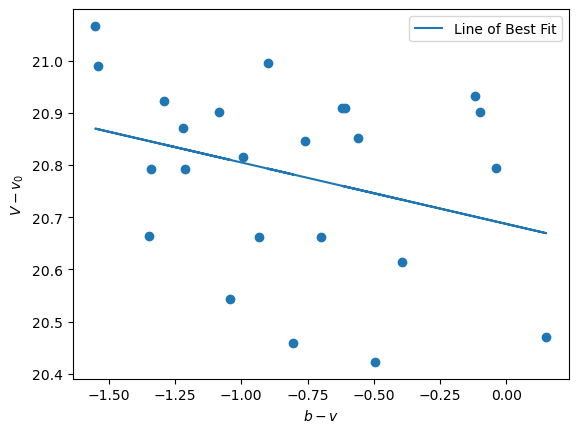

In [60]:
# Fitting for gamma and beta with Scipy curve_fit

df['V-V_INS'] = df['V'] - df['V_INS']
df['B_INS-V_INS'] = df['B_INS'] - df['V_INS']

def linear_fit(x, m, c):
    return m * x + c

params, _ = curve_fit(linear_fit, df['B_INS-V_INS'].to_numpy(), df['V-V_INS'].to_numpy())
gamma, beta = params[0], params[1]

print('Gamma:\t', gamma)
print('Beta:\t', beta)

plt.scatter(df['B_INS-V_INS'].to_numpy(), df['V-V_INS'].to_numpy())
plt.plot(df['B_INS-V_INS'].to_numpy(), df['B_INS-V_INS'].to_numpy() * gamma + beta, label='Line of Best Fit')

plt.xlabel('$b-v$')
plt.ylabel('$V-v_0$')
plt.legend()

Epsilon:	 1.1602652408347853
Eta:		 1.4818180804431966


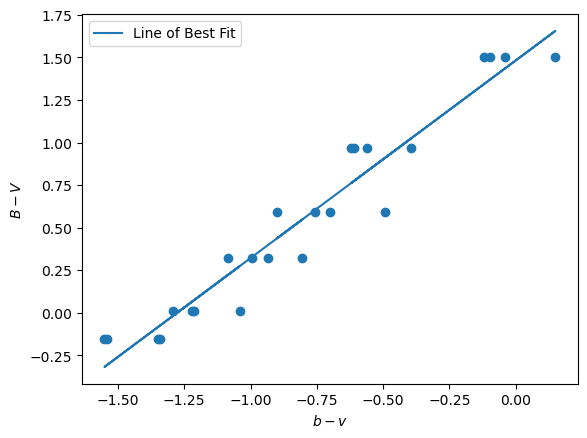

In [61]:
# Doing the same for eta and epsilon

df['B-V'] = df['B'] - df['V']

def linear_fit(x, m, c):
    return m * x + c

params, _ = curve_fit(linear_fit, df['B_INS-V_INS'].to_numpy(), df['B-V'].to_numpy())
epsilon, eta = params[0], params[1]

print('Epsilon:\t', epsilon)
print('Eta:\t\t', eta)

plt.scatter(df['B_INS-V_INS'].to_numpy(), df['B-V'].to_numpy())
plt.plot(df['B_INS-V_INS'].to_numpy(), df['B_INS-V_INS'].to_numpy() * epsilon + eta, label='Line of Best Fit')

plt.xlabel('$b-v$')
plt.ylabel('$B-V$')
plt.legend()

In [62]:
# Populating observed reference star magnitudes using the instrumental magnitudes

def return_V_obs(Bins_minus_Vins, V_ins):
    return beta + gamma * Bins_minus_Vins + V_ins

df['V_obs'] = df.apply(lambda row: return_V_obs(row['B_INS-V_INS'], row['V_INS']), axis=1)
df.head()


,Star,N_V,N_B,LST,RA_HS,DEC_DMS,V,B,RA_DEG,DEC_DEG,X,V_INS,B_INS,V-V_INS,B_INS-V_INS,B-V,V_obs
0,HR7235,14900000.0,49000000.0,19 29.6,19 05 24.6080,+13 51 48.518,2.990,3.000,286.352533,13.863477,1.159955,-17.932966,-19.225490,20.922966,-1.292525,0.010,2.906427
1,HR7235,14200000.0,43700000.0,22 18.6,19 05 24.6080,+13 51 48.518,2.990,3.000,286.352533,13.863477,1.583035,-17.880721,-19.101204,20.870721,-1.220483,0.010,2.950180
2,HR7235,13200000.0,40300000.0,23 10.2,19 05 24.6080,+13 51 48.518,2.990,3.000,286.352533,13.863477,1.986978,-17.801435,-19.013263,20.791435,-1.211828,0.010,3.028446
3,HR7235,10500000.0,27400000.0,00 09.4,19 05 24.6080,+13 51 48.518,2.990,3.000,286.352533,13.863477,2.981436,-17.552973,-18.594376,20.542973,-1.041403,0.010,3.256818
4,HR7298,4650000.0,19400000.0,19 32.8,19 13 45.4884,+39 08 45.477,4.398,4.243,288.439535,39.145966,1.005350,-16.668632,-18.219504,21.066632,-1.550872,-0.155,4.201214


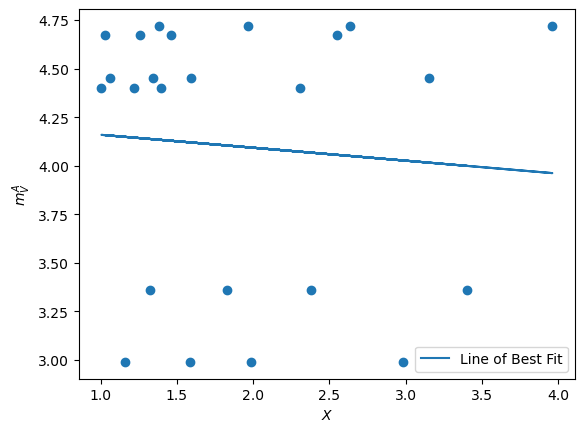

In [63]:
# Fitting to find k_V

params, _ = curve_fit(linear_fit, df['X'].to_numpy(), df['V'].to_numpy())
k_V, m = params[0], params[1]

plt.scatter(df['X'].to_numpy(), df['V'].to_numpy())
plt.plot(df['X'].to_numpy(), df['X'].to_numpy() * k_V + m, label='Line of Best Fit')

plt.xlabel('$X$')
plt.ylabel('$m_V^A$')
plt.legend()


In [64]:
target_V_estimate = gamma * (return_instrument_mag(7.7E5) - return_instrument_mag(3.56E5)) + beta + return_instrument_mag(3.56E5)

print('The estimated true V magnitude of our star is {:.3f}'.format(target_V_estimate))

print('The first orger colour correction index is just eta.')


The estimated true V magnitude of our star is 6.907
The first orger colour correction index is just eta.


In [65]:
# Let's check the target star around its coordinates.

target_table = simbad.query_region(SkyCoord(ra='19h34.1m', dec='+31d18m'), radius=100 * u.arcsec)
target_table

MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE,FLUX_B,FLUX_V,SCRIPT_NUMBER_ID
,"""h:m:s""","""d:m:s""",,,mas,mas,deg,,,,mag,mag,
object,str13,str13,int16,int16,float32,float32,int16,str1,str1,object,float32,float32,int32
Gaia DR3 2044818055433168768,19 34 05.2157,+31 18 17.341,14,14,0.079,0.091,90,A,O,2020yCat.1350....0G,--,--,1
